In [30]:
from Model.data_model import get_data
from Model.data_model import parse_game
from Model.top_players import get_player_name, get_one_hot, player_list
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Load data from db, Note: first time user must include the "load_new=True" flag in get_data
raw_games = get_data(load_new=False, time_control=[180])

Getting Data
Parsed time control
Linked to database
Done


In [72]:
list_games, list_white_players, list_black_players = parse_game(raw_games, bottom_move=8, top_move=32)
print("Number of positions loaded: {}".format(len(list_games)))

(45950, 3)
Number of positions loaded: 1047767


In [73]:
# Train Test Split
train_size = .8
(games_train,
games_test,
white_players_train,
white_players_test,
black_players_train,
black_players_test) = train_test_split(
    list_games,
    list_white_players,
    list_black_players)
# Convert all to tensors
games_train = tf.convert_to_tensor(games_train)
games_test = tf.convert_to_tensor(games_test)
white_players_train = tf.convert_to_tensor(white_players_train)
white_players_test = tf.convert_to_tensor(white_players_test)
black_players_train = tf.convert_to_tensor(black_players_train)
black_players_test = tf.convert_to_tensor(black_players_test)
# Confirm shapes
print_shapes = True
if print_shapes:
    print("games_train shape: {}".format(games_train.shape))
    print("games_test shape: {}".format(games_test.shape))
    print("white_players_train shape: {}".format(white_players_train.shape))
    print("white_players_test shape: {}".format(white_players_test.shape))
    print("black_players_train shape: {}".format(black_players_train.shape))
    print("black_players_test shape: {}".format(black_players_test.shape))

games_train shape: (785825, 8, 8)
games_test shape: (261942, 8, 8)
white_players_train shape: (785825,)
white_players_test shape: (261942,)
black_players_train shape: (785825,)
black_players_test shape: (261942,)


In [113]:
# White player model
num_neurons = 512
num_layers = 8
batch_size = 2048
epochs = 24
white_model = keras.Sequential()
white_model.add(layers.Flatten(input_shape=(8, 8)))
for n in range(num_layers):
    white_model.add(layers.Dense(num_neurons, activation='relu'))
white_model.add(layers.Dense(47, activation='softmax'))
white_model.compile(
    optimizer=keras.optimizers.legacy.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# Run cell to train model
white_history = white_model.fit(
    games_train,
    white_players_train,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/24
384/384 [==============================] - 21s 55ms/step - loss: 2.9461 - sparse_categorical_accuracy: 0.2112
Epoch 2/24
384/384 [==============================] - 21s 54ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.6637
Epoch 3/24
384/384 [==============================] - 21s 54ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.8673
Epoch 4/24
384/384 [==============================] - 21s 55ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.8861
Epoch 5/24
384/384 [==============================] - 21s 55ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.9209
Epoch 6/24
384/384 [==============================] - 21s 56ms/step - loss: 0.3448 - sparse_categorical_accuracy: 0.9295
Epoch 7/24
384/384 [==============================] - 21s 55ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.9291
Epoch 8/24
384/384 [==============================] - 21s 55ms/step - loss: 0.2610 - sparse_categorical_accuracy: 0.9478
Epoch 9/24
384/384 [============

In [ ]:
# Black player model
black_model = keras.Sequential()
black_model.add(layers.Flatten(input_shape=(8, 8)))
for n in range(num_layers):
    black_model.add(layers.Dense(num_neurons, activation='relu'))
black_model.add(layers.Dense(47, activation='softmax'))
black_model.compile(
    optimizer=keras.optimizers.legacy.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# Run cell to train model
black_history = black_model.fit(
    games_train,
    black_players_train,
    batch_size=batch_size,
    epochs=epochs,
)

In [114]:
# BEST RESULTS 
# Sparse categorical accuracy = .9928
# Test accuracy = 
# num_neurons = 512
# num_layers = 8
# batch_size = 2048
# epochs = 24
white_score, white_acc = white_model.evaluate(games_test, white_players_test, batch_size=batch_size)
black_score, black_acc = black_model.evaluate(games_test, black_players_test, batch_size=batch_size)
print("White score:{} White Accuracy:{}".format(white_score, white_acc))
print("Black score:{} Black Accuracy:{}".format(black_score, black_acc))

128/128 [==============================] - 3s 22ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9953
White score:0.007661836221814156 White Accuracy:0.9967778921127319
Black score:0.017476800829172134 Black Accuracy:0.9953081011772156


In [115]:
# Test accuracy
white_players_pred = np.argmax(white_model.predict(games_test), axis=1)
white_class_report = classification_report(white_players_test, white_players_pred, zero_division=0, labels=np.arange(0,len(player_list),1), target_names=player_list)
print("WHITE PLAYER CLASSIFICATION REPORT")
print(white_class_report)
black_players_pred = np.argmax(black_model.predict(games_test), axis=1)
black_class_report = classification_report(black_players_test, black_players_pred, zero_division=0, labels=np.arange(0,len(player_list),1), target_names=player_list)
print("BLACK PLAYER CLASSIFICATION REPORT")
print(black_class_report)

8186/8186 [==============================] - 16s 2ms/step
WHITE PLAYER CLASSIFICATION REPORT
                      precision    recall  f1-score   support

       MagnusCarlsen       0.00      0.00      0.00         0
          nihalsarin       1.00      0.99      1.00      7099
    DanielNaroditsky       1.00      1.00      1.00     43571
              Hikaru       1.00      1.00      1.00     41416
         Sibelephant       1.00      1.00      1.00       548
           LyonBeast       1.00      0.97      0.99      1053
           lachesisQ       1.00      1.00      1.00     11506
    spicycaterpillar       0.99      0.99      0.99      4109
         Bigfish1995       1.00      1.00      1.00     16174
         dropstoneDP       1.00      1.00      1.00      3611
      Baku_Boulevard       1.00      1.00      1.00       693
               GMWSO       1.00      0.98      0.99      2582
        Firouzja2003       0.99      1.00      0.99     25910
           AnishGiri       1.00      1

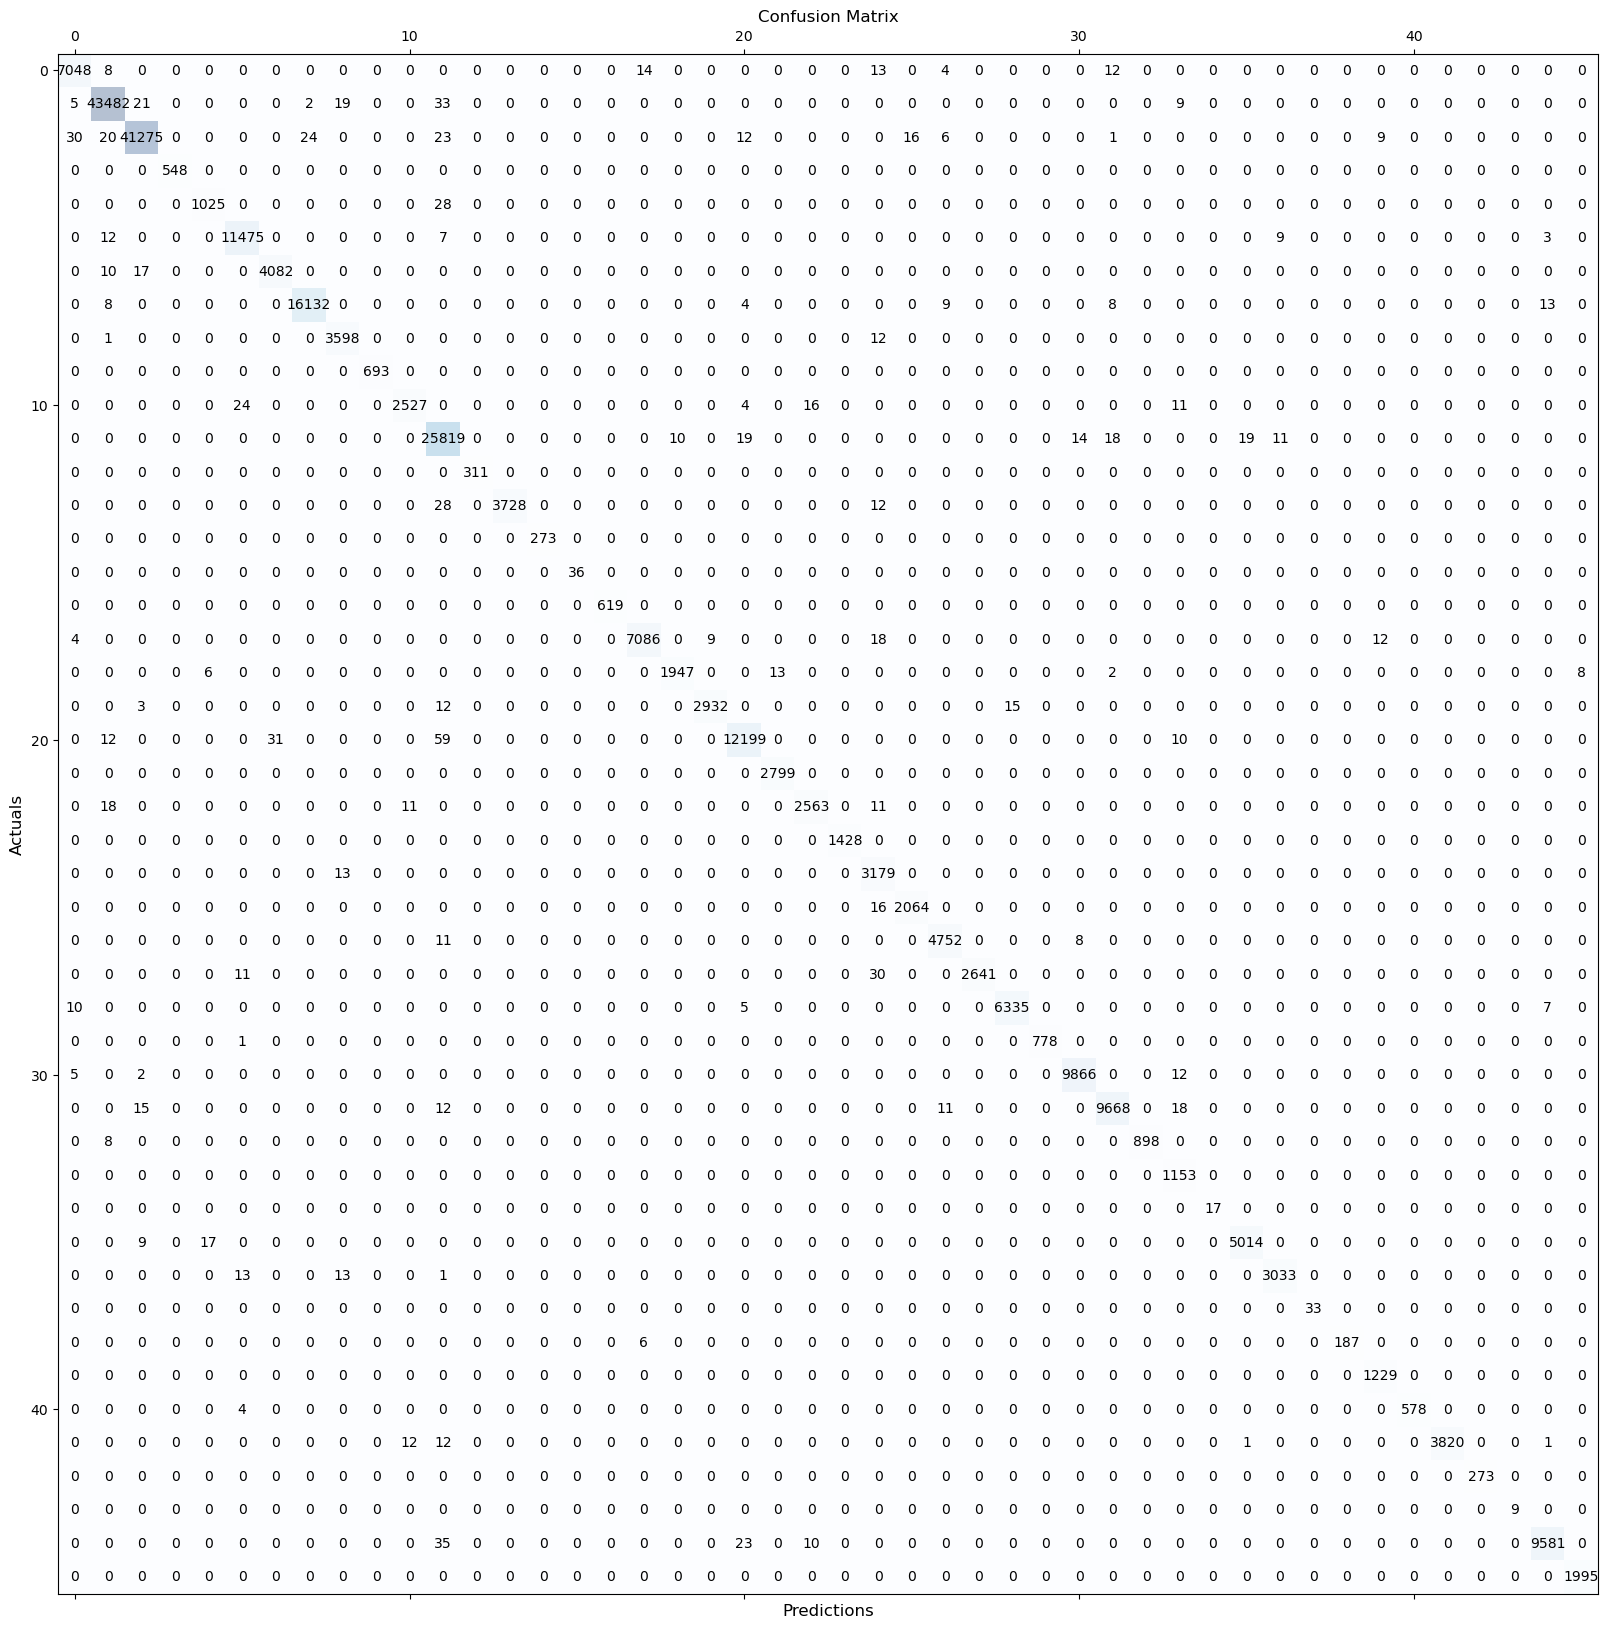

In [106]:
# Create confusion matrix
conf_matrix = confusion_matrix(white_players_test, white_players_pred)
ig, ax = plt.subplots(figsize=(20,20))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

In [109]:
# Want to show how many occurances there are of each player
for player in player_list:
    print("{}:{}".format(player, np.count_nonzero(white_players_pred == get_one_hot(player))))

MagnusCarlsen:0
nihalsarin:7102
DanielNaroditsky:43579
Hikaru:41342
Sibelephant:548
LyonBeast:1048
lachesisQ:11528
spicycaterpillar:4113
Bigfish1995:16158
dropstoneDP:3643
Baku_Boulevard:693
GMWSO:2550
Firouzja2003:26080
AnishGiri:311
Konavets:3728
FabianoCaruana:273
LOVEVAE:36
chesspanda123:619
Duhless:7106
FairChess_on_YouTube:1957
NikoTheodorou:2941
Jospem:12266
Msb2:2812
Polish_fighter3000:2589
Alexander_Zubov:1428
BogdanDeac:3291
Azerichess:2080
Oleksandr_Bortnyk:4782
Grischuk:2641
wonderfultime:6350
GOGIEFF:778
GM_dmitrij:9888
mishanick:9709
RaunakSadhwani2005:898
viditchess:1213
TRadjabov:17
Annawel:5034
Zhuu96:3053
KuybokarovTemur:33
DenLaz:187
howitzer14:1250
fireheart92:578
ShimanovAlex:3820
crescentmoon2411:273
Ni-Hua:9
Salem-AR:9605
OparinGrigoriy:2003


In [116]:
# Save models
white_model.save('white_player_model')
black_model.save('black_player_model')

INFO:tensorflow:Assets written to: white_player_model/assets
INFO:tensorflow:Assets written to: black_player_model/assets
